In [1]:
import pandas as pd
import os
import sys
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Set the current working directory to the project root
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(ROOT_DIR)

In [2]:
from src.data_management.loaders import load_labeled_df

df = load_labeled_df('phase0_baseline_labeled.parquet')
df.head()

,id,text,narratives,subnarratives,language,narrative_ids,subnarrative_ids,num_narratives,num_subnarratives,word_count,word_count_bin,labels
0,BG_670.txt,Опитът на колективния Запад да „обезкърви Руси...,[URW: Blaming the war on others rather than th...,[URW: Blaming the war on others rather than th...,BG,"[11, 12, 14]","[88, 70, 74, 86]",4,4,248,101-250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ..."
1,A7_URW_BG_4793.txt,"Цончо Ганев, “Възраждане”: Обещали сме на Укра...",[URW: Discrediting Ukraine],[URW: Discrediting Ukraine: Situation in Ukrai...,BG,[13],[81],1,1,503,501-1000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,BG_3245.txt,Подкрепата за Киев от страна на Запада вече не...,"[URW: Discrediting the West, Diplomacy, URW: D...","[URW: Discrediting the West, Diplomacy: The We...",BG,"[13, 14]","[81, 90, 87]",3,3,190,101-250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
3,A9_BG_5190.txt,"Дмитрий Медведев: НПО-та, спонсорирани от Соро...","[URW: Discrediting the West, Diplomacy, URW: D...","[URW: Discrediting the West, Diplomacy: Other,...",BG,"[13, 14]","[84, 86]",2,2,275,251-500,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,A9_BG_3379.txt,Британски дипломат обвини Запада за украинския...,"[URW: Discrediting the West, Diplomacy, URW: P...","[URW: Discrediting the West, Diplomacy: Other,...",BG,"[19, 14]","[86, 103]",2,2,237,101-250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [3]:
from skmultilearn.model_selection import iterative_train_test_split

# Split the dataset into training and testing sets
X = df.index.to_numpy().reshape(-1, 1)
y = np.array(df['labels'].tolist())

train_val_indices, y_train_val, test_indices, y_test = iterative_train_test_split(X, y, test_size = 0.2)


train_indices, y_train, val_indices, y_val = iterative_train_test_split(train_val_indices, y_train_val, test_size = 0.25)

train_df = df.loc[train_indices.flatten()]
val_df = df.loc[val_indices.flatten()]
test_df = df.loc[test_indices.flatten()]


# 5. Verify the results
print("Original dataset shape:", df.shape)
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

print("\nExample of train_df head:")
print(train_df.head())

Original dataset shape: (1699, 12)
Train set shape: (1000, 12)
Validation set shape: (334, 12)
Test set shape: (365, 12)

Example of train_df head:
                    id                                               text  \
1   A7_URW_BG_4793.txt  Цончо Ганев, “Възраждане”: Обещали сме на Укра...   
6           BG_855.txt  Русия забрани разпространението на десетки мед...   
7           BG_751.txt  US военен: Путин ни изигра така, както Рейгън ...   
11      A9_BG_3298.txt  Обан се присмя на идеята на САЩ да отпуснат но...   
23  A7_URW_BG_3808.txt  Посланик Барбин: датските депутати са обсебени...   

                                           narratives  \
1                         [URW: Discrediting Ukraine]   
6   [URW: Distrust towards Media, URW: Distrust to...   
7   [URW: Praise of Russia, URW: Discrediting Ukra...   
11  [URW: Discrediting the West, Diplomacy, URW: D...   
23                [URW: Amplifying war-related fears]   

                                        subnar

In [4]:
import torch


all_labels = np.array(train_df['labels'].tolist())

num_positives = np.sum(all_labels)
num_negatives = all_labels.size - num_positives

# Calculate the weight
pos_weight = num_negatives / num_positives

In [5]:
from src.data_management.label_parser import get_label_mappings

label_to_id, id_to_label, narrative_to_subnarrative_ids = get_label_mappings()
sub_to_narr_id_map = {}

# Create a mapping from sub-narrative IDs to their parent narrative IDs
for narr_id, sub_ids_list in narrative_to_subnarrative_ids.items():
    for sub_id in sub_ids_list:
        sub_to_narr_id_map[sub_id] = narr_id

# This gives you a map like: { sub_id_A: narr_id_1, sub_id_B: narr_id_1, ... }
# It's useful to also have a simple list of all parent-child ID pairs
parent_child_pairs = list(sub_to_narr_id_map.items())

In [6]:
MODEL_NAME = "xlm-roberta-base"
EPOCHS = 20  # Set a high number; early stopping will handle it
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
H_LAMBDA = 2.0
PATIENCE = 3
MODEL_OUTPUT_PATH = "models/phase0_xlmr_best_model.bin"

print("Configuration set.")

Configuration set.


In [7]:
import torch
from src.training.setup import init_model_and_tokenizer, setup_optimizer_and_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model, tokenizer = init_model_and_tokenizer(
    model_name=MODEL_NAME,
    device=device,
    num_total_labels=len(df['labels'].iloc[0]),
    id_to_label= id_to_label,
    label_to_id= label_to_id,
)

pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float).to(device)

/home/twoface/Documents/Passau/masterarbeit/hybrid-text-classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully.


In [8]:
from src.data_management.datasets import NarrativeClassificationDataset
from torch.utils.data import DataLoader

train_dataset = NarrativeClassificationDataset(
    dataframe= train_df,
    tokenizer=tokenizer,
    max_length=512,
)
val_dataset = NarrativeClassificationDataset(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=512,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

In [9]:
optimizer, scheduler = setup_optimizer_and_scheduler(
    model=model,
    train_dataloader=train_dataloader,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
)

Optimizer set up successfully.
Scheduler set up successfully.


In [10]:
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
print("Model and all training components are ready.")

Model and all training components are ready.


In [11]:
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_f1_micro': []}

In [12]:
from src.training.engine import evaluate, train_epoch


for epoch in range(EPOCHS):
    print(f"\n{'='*20} Epoch {epoch + 1}/{EPOCHS} {'='*20}")

    # --- Call the training function from the engine.py ---
    avg_train_loss = train_epoch(
        model, 
        train_dataloader, 
        optimizer, 
        scheduler, 
        loss_fn,
        device, 
        parent_child_pairs, 
        H_LAMBDA
    )
    history['train_loss'].append(avg_train_loss)

    # --- Call the evaluation function from the engine.py ---
    avg_val_loss, val_metrics = evaluate(
        model, 
        val_dataloader, 
        loss_fn,
        device, 
        H_LAMBDA, 
        parent_child_pairs
    )
    history['val_loss'].append(avg_val_loss)
    history['val_f1_micro'].append(val_metrics['f1_micro'])
    
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation F1 Micro: {val_metrics['f1_micro']:.4f}")

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_OUTPUT_PATH)
        print(f"Validation loss improved. Saving model to {MODEL_OUTPUT_PATH}")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve. Early stopping counter: {epochs_no_improve}/{PATIENCE}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {PATIENCE} epochs with no improvement.")
        break

print("\n--- Training Complete ---")
print(f"Best validation loss achieved: {best_val_loss:.4f}")
print(f"Best model saved to {MODEL_OUTPUT_PATH}")


==================== Epoch 1/20 ====================


Training: 100%|██████████| 63/63 [02:03<00:00,  1.96s/it]


Average Training Loss: 1.9265
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Average Validation Loss: 1.1301
Validation Loss: 1.1301
Validation F1 Micro: 0.1331
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 2/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.92s/it]


Average Training Loss: 1.0920
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]


Average Validation Loss: 1.0445
Validation Loss: 1.0445
Validation F1 Micro: 0.1557
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 3/20 ====================


Training: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


Average Training Loss: 0.9900
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]


Average Validation Loss: 0.9414
Validation Loss: 0.9414
Validation F1 Micro: 0.1836
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 4/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.90s/it]


Average Training Loss: 0.9092
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]


Average Validation Loss: 0.8822
Validation Loss: 0.8822
Validation F1 Micro: 0.1946
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 5/20 ====================


Training: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


Average Training Loss: 0.8540
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Average Validation Loss: 0.8635
Validation Loss: 0.8635
Validation F1 Micro: 0.1986
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 6/20 ====================


Training: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


Average Training Loss: 0.8189
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


Average Validation Loss: 0.8366
Validation Loss: 0.8366
Validation F1 Micro: 0.2034
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 7/20 ====================


Training: 100%|██████████| 63/63 [02:01<00:00,  1.93s/it]


Average Training Loss: 0.7821
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


Average Validation Loss: 0.8123
Validation Loss: 0.8123
Validation F1 Micro: 0.2066
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 8/20 ====================


Training: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


Average Training Loss: 0.7500
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Average Validation Loss: 0.8179
Validation Loss: 0.8179
Validation F1 Micro: 0.1954
Validation loss did not improve. Early stopping counter: 1/3

==================== Epoch 9/20 ====================


Training: 100%|██████████| 63/63 [02:01<00:00,  1.93s/it]


Average Training Loss: 0.7282
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Average Validation Loss: 0.8218
Validation Loss: 0.8218
Validation F1 Micro: 0.2152
Validation loss did not improve. Early stopping counter: 2/3

==================== Epoch 10/20 ====================


Training: 100%|██████████| 63/63 [02:01<00:00,  1.92s/it]


Average Training Loss: 0.7069
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Average Validation Loss: 0.7872
Validation Loss: 0.7872
Validation F1 Micro: 0.2196
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 11/20 ====================


Training: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it]


Average Training Loss: 0.6845
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


Average Validation Loss: 0.8072
Validation Loss: 0.8072
Validation F1 Micro: 0.2216
Validation loss did not improve. Early stopping counter: 1/3

==================== Epoch 12/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.91s/it]


Average Training Loss: 0.6716
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Average Validation Loss: 0.7865
Validation Loss: 0.7865
Validation F1 Micro: 0.2343
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 13/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.90s/it]


Average Training Loss: 0.6576
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]


Average Validation Loss: 0.7813
Validation Loss: 0.7813
Validation F1 Micro: 0.2302
Validation loss improved. Saving model to models/phase0_xlmr_best_model.bin

==================== Epoch 14/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.92s/it]


Average Training Loss: 0.6441
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Average Validation Loss: 0.7905
Validation Loss: 0.7905
Validation F1 Micro: 0.2229
Validation loss did not improve. Early stopping counter: 1/3

==================== Epoch 15/20 ====================


Training: 100%|██████████| 63/63 [02:00<00:00,  1.91s/it]


Average Training Loss: 0.6348
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


Average Validation Loss: 0.7937
Validation Loss: 0.7937
Validation F1 Micro: 0.2277
Validation loss did not improve. Early stopping counter: 2/3

==================== Epoch 16/20 ====================


Training: 100%|██████████| 63/63 [01:58<00:00,  1.88s/it]


Average Training Loss: 0.6239
Running evaluation on the validation set...


Validating: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]

Average Validation Loss: 0.7901
Validation Loss: 0.7901
Validation F1 Micro: 0.2302
Validation loss did not improve. Early stopping counter: 3/3
Early stopping triggered after 3 epochs with no improvement.

--- Training Complete ---
Best validation loss achieved: 0.7813
Best model saved to models/phase0_xlmr_best_model.bin


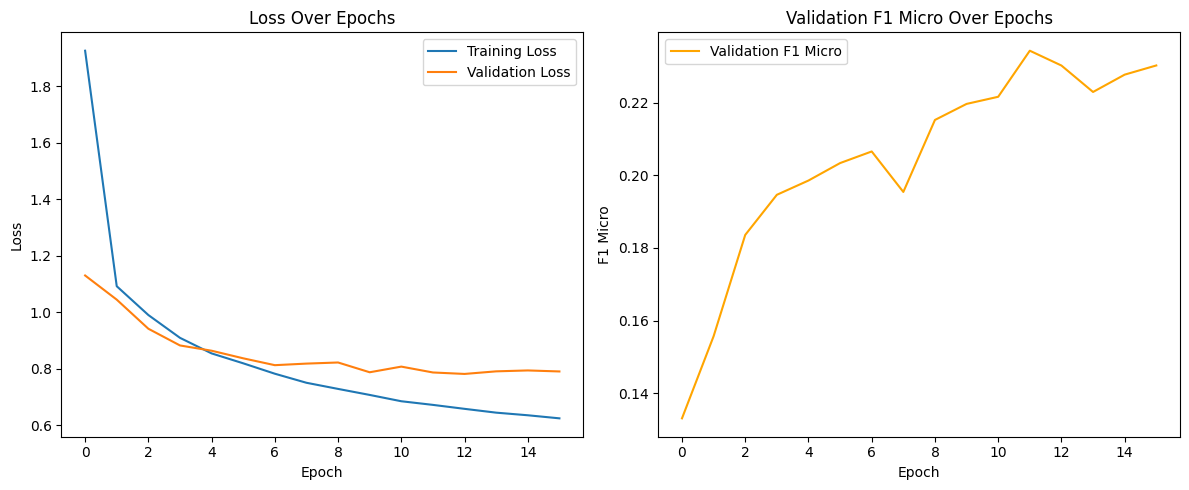

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1_micro'], label='Validation F1 Micro', color='orange')
plt.title('Validation F1 Micro Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Micro')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import json

# Prepare results dictionary
results = {
    "model_name": MODEL_NAME,
    "epochs_trained": len(history['train_loss']),
    "best_val_loss": best_val_loss,
    "val_f1_micro": history['val_f1_micro'],
    "val_loss": history['val_loss'],
    "train_loss": history['train_loss'],
    "config": {
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "h_lambda": H_LAMBDA,
        "patience": PATIENCE,
        "pos_weight": float(pos_weight),
        "model_output_path": MODEL_OUTPUT_PATH,
    }
}

# Save results to a JSON file
with open("model_results_phase0_xlmr.json", "w") as f:
    json.dump(results, f, indent=2)

print("Model results saved to model_results_phase0_xlmr.json")

Model results saved to model_results_phase0_xlmr.json
